In [4]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import galpy
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
import astropy.units as u
from astropy.coordinates import SkyCoord
#from matplotlib.backends.backend_pdf import PdfPages
import imageio
import os
import glob
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial import ConvexHull


plt.rcParams["font.family"] = "Times New Roman"
hdul = fits.open('asu_topcat.fits') # open a FITS file of the 256 stars
data = hdul[1].data  # assume the first extension is a table
t = Table(data)
#initialize 
ra_list = t.columns['RA_ICRS']
dec_list = t.columns['DE_ICRS']
pmra_list = t.columns['pmRA']
parallax = (t.columns['Plx'])/1000 #units of plx are milliarcseconds (mas) &&& 1 arc second = 1000 mas 
pmdec_list = t.columns['pmDE']
rv_list = t.columns['RV']
gcR_list = t.columns['gcR']
gcPHI_list = t.columns['gcPHI']
gcZ_list = t.columns['gcZ']
gcPHI_list = -(gcPHI_list -np.pi)
gcvR_list = t.columns['gcvR']
gcvPHI_list = t.columns['gcvPHI']
gcvZ_list = t.columns['gcvZ']

In [5]:
def OrbitIntegrate3D(time, pathname, increment = 5): 
    
    orbits= Orbit(vxvv=[gcR_list*u.pc,gcvR_list*u.km/u.s,gcvPHI_list*u.km/u.s,gcZ_list*u.pc,gcvZ_list*u.km/u.s,
                        gcPHI_list*u.rad])
    ts= np.linspace(0,time,10000)*u.Myr
    orbits.integrate(ts,MWPotential2014)
    sun = Orbit()
    sun.integrate(ts,MWPotential2014)
    
    tlist = []
    density = []
    xrangelist = []
    yrangelist = []
    zrangelist = []
    if time < 0:
        plotrange = np.arange(time, 0, increment)*u.Myr
        angle_noPOV = 45
    else:
        plotrange = np.arange(0, time+increment, increment)*u.Myr
        angle_noPOV = 135
    
     
    for i in plotrange:  
        fig = plt.figure(figsize = (8,8))
        ax1 = fig.gca(projection='3d')

        if time < 0:
            ax1.set_title('t='+ str(i+120*u.Myr)  +'     ('  + str(i)+' ago)'  , fontsize= 16)
        else:
            ax1.set_title('t='+ str(i+120*u.Myr)  +'     ('  + str(i)+' future)'  , fontsize= 16)

        #rotating axes to get the rest frame of the stream
        theta = np.median(orbits.phi(i))
        x_p = orbits.x(i)*np.cos(theta) + orbits.y(i)*np.sin(theta)
        y_p = -orbits.x(i)*np.sin(theta) + orbits.y(i)*np.cos(theta)
        z_p = orbits.z(i)        
        vx_p = orbits.vx(i)*np.cos(theta) + orbits.vy(i)*np.sin(theta)
        vy_p = -orbits.vx(i)*np.sin(theta) + orbits.vy(i)*np.cos(theta)
        vz_p = orbits.vz(i)
        
        x_p_sun = sun.x(i)*np.cos(theta) + sun.y(i)*np.sin(theta)
        y_p_sun = -sun.x(i)*np.sin(theta) + sun.y(i)*np.cos(theta) 
        z_p_sun = sun.z(i)
        #print(x_p-np.median(x_p))
        x_psubmed = x_p-np.median(x_p)
        y_psubmed = y_p-np.median(y_p)
        z_psubmed = z_p-np.median(z_p)

        den = ConvexHullDensity(x_psubmed, y_psubmed, z_psubmed)
        #print('t='+ str(i+120*u.Myr), 'i:', i, '   density:', den)
        density.append(den)
        tlist.append((i+120*u.Myr))
        
        xrangelist.append(max(x_psubmed)-min(x_psubmed))
        yrangelist.append(max(y_psubmed)-min(y_psubmed))
        zrangelist.append(max(z_psubmed)-min(z_psubmed))
        
                


        ax1.quiver(x_psubmed, y_psubmed, z_psubmed, vx_p-np.median(vx_p), vy_p-np.median(vy_p), vz_p-np.median(vz_p), length = .009, arrow_length_ratio = 0.25, colors = 'k')
        ax1.scatter(x_psubmed, y_psubmed, z_psubmed, s=50, color = 'c', edgecolors = 'k')
        #ax1.scatter(x_p-np.median(x_p), y_p-np.median(y_p), zs = 0, zdir = 'z', s=50, color = 'c', edgecolors = 'k')
        #ax1.scatter(x_p-np.median(x_p), z_p-np.median(z_p), zs = 0, zdir = 'y', s=50, color = 'c', edgecolors = 'k')
        #ax1.scatter(y_p-np.median(y_p), z_p-np.median(z_p), zs = 0, zdir = 'x', s=50, color = 'c', edgecolors = 'k')

        #ax1.quiver(sun.x(i), sun.y(i), (sun.vx(i)-np.median(orbits.vx(i))), (sun.vy(i)-np.median(orbits.vy(i))), width = 1/400)

        ax1.scatter(x_p_sun-np.median(x_p), y_p_sun-np.median(y_p), z_p_sun-np.median(z_p), color = 'orange', s = 50, edgecolors = 'k')
        
        pts =np.array(list(zip(x_psubmed, y_psubmed, z_psubmed)))
        hull = ConvexHull(pts)
        for s in hull.simplices:
            #print(s)
            #print(s[0])
            s = np.append(s, s[0])  # Here we cycle back to the first coordinate
            #print(pts[s,0])
            ax1.plot(pts[s, 0], pts[s, 1], pts[s, 2], ls = "-", color = "red")
        
        
        ax1.set_xlabel('X* (kpc)')
        ax1.set_ylabel('Y* (kpc)')
        ax1.set_zlabel('Z (kpc)')
        ax1.set_xlim3d(-1.75, +1.75)
        ax1.set_ylim3d(-1.75, +1.75)
        ax1.set_zlim3d(-0.3, +0.3)
        #x1, y1, _ = proj3d.proj_transform(-.5,-2.3,-.25, ax1.get_proj())
        #ax1.annotate("Increasing Galactic Radius", xy=(x1, y1), xytext=(0, 0), arrowprops=dict(arrowstyle="->"), va = 'center_baseline')
        #ax.text(9, 0, 0, "red", color='red')
    
        #print(i)
        ax1.view_init(30, angle_noPOV)
        
        #print('angle1', angle_noPOV)
        
        # the times to rotate the POV
        if i == -185.0*u.Myr:
            for angle in range(45, 138, 3):
                ax1.view_init(30, angle)
                plt.savefig(pathname+str(i)+'_'+str(angle)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
                #print("angle2", angle)
            angle_noPOV = 135
                
        elif i == 60.0*u.Myr:
            for angle in range(135, 228, 3):
                ax1.view_init(30, angle)
                plt.savefig(pathname+str(i)+'_'+str(angle)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
                #print("angle2", angle)
            angle_noPOV = 225
        
        elif i == 210.0*u.Myr:
            for angle in range(225, 318, 3):
                ax1.view_init(30, angle)
                plt.savefig(pathname+str(i)+'_'+str(angle)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
                #print("angle2", angle)
            angle_noPOV = 315 
        
        elif i == 320.0*u.Myr:
            for angle in range(315, 408, 3):
                ax1.view_init(30, angle)
                plt.savefig(pathname+str(i)+'_'+str(angle)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
       #         ax1.view_init(30, angle+90)
                #print('angle4', angle)
            angle_noPOV = 405
            
        
        ####change the ranges to 90 differences OR change inital angle 

        plt.savefig(pathname+str(i)+'.png', bbox_inches='tight', dpi = 150, pad_inches = 1)
        plt.close(fig)
    
    return density, tlist, xrangelist, yrangelist, zrangelist
        
def ConvexHullDensity(x, y, z):
    pts = list(zip(x, y, z))
    hull = ConvexHull(pts)
    volume = hull.volume
    density = 256/volume #number of stars / volume
    
    return density
    

def gifmaker(foldername, gifname):
    filenames = sorted(glob.glob(foldername), key = os.path.getmtime)
    with imageio.get_writer(gifname, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            

In [6]:
densitylist, tlist, xrangelist, yrangelist, zrangelist = OrbitIntegrate3D(-220.,  pathname = 'gifConvexHull/plot')

In [7]:
densitylist2, tlist2, xrangelist2, yrangelist2, zrangelist2 = OrbitIntegrate3D(380.,  pathname='gifConvexHull/plot')

In [159]:
gifmaker('gifConvexHull/plot*', 'gifConvexHull/XYZ.gif')

In [9]:
totaldensitylist = np.array(densitylist+densitylist2)
totaltimelist = (tlist+tlist2)
totalxrangelist = (xrangelist+xrangelist2)
totalyrangelist = (yrangelist+yrangelist2)
totalzrangelist = (zrangelist+zrangelist2)
tlistnew = [x.value for x in totaltimelist]
#totaldensitylist

In [ ]:
#totalyrangelist

In [8]:
#max(totaldensitylist) #kpc^-3 

In [ ]:
#totaldensitylist

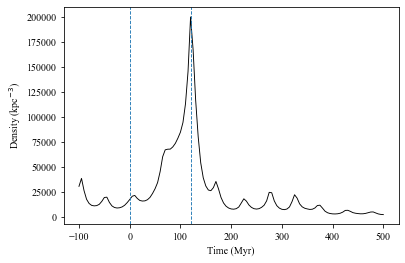

In [10]:
plt.plot(tlistnew, totaldensitylist, color = 'k', linewidth = 0.9)
plt.xlabel("Time (Myr)")
plt.ylabel("Density (kpc$^{-3}$)")

#y1 = 0
#y2 = 200000
#plt.vlines(0, ymin=y1, ymax=y2)
plt.axvline(x=0, linestyle = '--', linewidth = 0.9)
plt.axvline(x=120, linestyle = '--', linewidth = 0.9)

plt.savefig('densityplot.png', bbox_inches='tight', dpi = 150) #, pad_inches = 1)


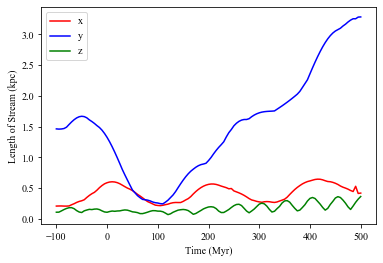

In [11]:
plt.plot(tlistnew, totalxrangelist, color = 'red', linewidth = 1.5, label ='x')
plt.plot(tlistnew, totalyrangelist, color = 'blue', linewidth = 1.5, label = 'y')
plt.plot(tlistnew, totalzrangelist, color = 'green', linewidth = 1.5, label='z')
plt.legend()
plt.xlabel('Time (Myr)')
plt.ylabel('Length of Stream (kpc)')
plt.savefig('length.png', bbox_inches='tight', dpi = 150)

In [13]:
orbits= Orbit(vxvv=[gcR_list*u.pc,gcvR_list*u.km/u.s,gcvPHI_list*u.km/u.s,gcZ_list*u.pc,gcvZ_list*u.km/u.s,
                        gcPHI_list*u.rad])
time = 380.
ts= np.linspace(0,time,10000)*u.Myr
orbits.integrate(ts,MWPotential2014)

In [14]:
i=200*u.Myr

theta = np.median(orbits.phi(i))
x_p = orbits.x(i)*np.cos(theta) + orbits.y(i)*np.sin(theta)
y_p = -orbits.x(i)*np.sin(theta) + orbits.y(i)*np.cos(theta)
z_p = orbits.z(i)        
vx_p = orbits.vx(i)*np.cos(theta) + orbits.vy(i)*np.sin(theta)
vy_p = -orbits.vx(i)*np.sin(theta) + orbits.vy(i)*np.cos(theta)
vz_p = orbits.vz(i)


x_psubmed = x_p-np.median(x_p)
y_psubmed = y_p-np.median(y_p)
z_psubmed = z_p-np.median(z_p)


pts =np.array(list(zip(x_psubmed, y_psubmed, z_psubmed)))

In [15]:
hull = ConvexHull(pts)
hull.volume

0.017145791174039412

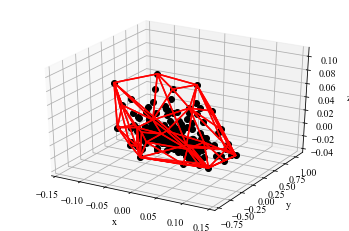

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull


# 8 points defining the cube corners
#pts = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
#                [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], ])

#hull = ConvexHull(pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot defining corner points
ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
pts =np.array(list(zip(x_psubmed, y_psubmed, z_psubmed)))
hull = ConvexHull(pts)
for s in hull.simplices:
    #print(s)
    #print(s[0])
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    #print(pts[s,0])
    ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

In [53]:
#Trying to do a cube convex hull

x1 = 0, 0, 0, 1, 1,
y1 = 0, 0, 1, 1, 0,
z1 = 0, 1, 1, 0, 0

#pts1 = list(zip(x1, y1, z1))
pts1 = [(0,0,0), (0,0,3), (3,0,0), (0,3,3), (3,0,3), (0,3,0), (3,3,0), (3,3,3)]
hull1 = ConvexHull(pts1)
volume1 = hull1.volume
density1 = 5/volume1 #number of stars / volume
pts1 = np.array(pts1)